# Single Variable Regression 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.simplefilter("ignore")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import patches
from datascience import *
%matplotlib inline
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

Suppose we have some data that look like this:

![title](figure1.png)

In Data 8 we learned that $x$ and $y$ above have some **correlation coefficient** $r$, which is a measure of the strength of the linear relationship between the two variables.

It looks like there is some positive linear association between $x$ and $y$ such that larger values of $x$ correspond to larger values of $y$. We therefore expect $r$ to be some positive number between 0 and 1, but not exactly 0 or exactly 1.

First, let's convert the data (stored in the arrays `x` and `y`) to standard units. To convert a set of data points to standard units, we subtract out the mean of the data and scale by the standard deviation. This has the effect of changing the data so that the data in standard units have mean 0 and  standard deviation 1. Below we construct a function that does this.

$$
x_{su} = \dfrac{x - \mu_x}{\sigma_x}
$$

In [2]:
def standard_units(array):
    return (array - np.mean(array)) / np.std(array)

In [3]:
# Hide this.
np.random.seed(42)
x = np.random.uniform(0, 10, 100)
noise = np.random.randn(100) * 4
y = 1.5 * x + noise

In [4]:
x_standard = standard_units(x)
y_standard = standard_units(y)

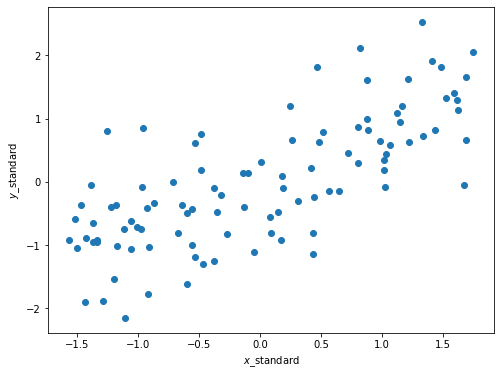

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(x_standard, y_standard)
plt.xlabel('$x$_standard')
plt.ylabel('$y$_standard');

The plot looks the same as before, except now the axes are scaled such that we measure $x$ and $y$ in standard units. Now recall that $r$ is calculated as the average of the product of two variables, when the variables are measured in standard units. Below we define a function that calculates $r$, assuming that the inputs have already been converted to standard units.

In [6]:
def correlation(array1, array2):
    return np.mean(array1 * array2)

What is the correlation between these two variables?

In [7]:
correlation(x_standard, y_standard)

0.7351364076052979

Recall from Data 8 that we use $r$ to form a line called the *regression line*, which makes predictions for $y$ given some $x$. Our prediction for $y$ in standard units is $r \cdot x$. If we want to fit this regression line in the original units, recall that the slope of this line is given by

$$
\text{slope} = r \cdot \dfrac{\hat{\sigma}_y}{\hat{\sigma}_x}
$$

and the intercept is given by

$$
\text{intercept} = \hat{\mu}_y - \text{slope} \cdot \hat{\mu}_x
$$

where $\hat{\sigma}_x$ is the observed standard deviation of a variable $x$ and $\hat{\mu}_x$ is the observed mean. Our regression line will have the form

$$
y = \hat{\alpha} + \hat{\beta} x
$$

where $\hat{\alpha}$ is the intercept from above and $\hat{\beta}$ the slope.

Below we plot this line.

In [8]:
r = correlation(x_standard, y_standard)
slope = r * np.std(y) / np.std(x)
intercept = np.mean(y) - slope * np.mean(x)

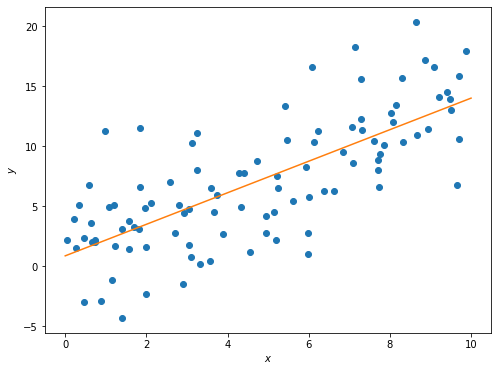

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.plot(np.linspace(0, 10), slope * np.linspace(0, 10) + intercept, color='tab:orange')
plt.xlabel('$x$')
plt.ylabel('$y$');

Let's take a closer look at the slope we found.

In [10]:
print('Slope: ', slope)

Slope:  1.3160907091507876


To generate the data above, we started with some range of $x$ values, and generated $y$ as a linear function of $x$ with some random noise added in. Take a look:

In [11]:
np.random.seed(42)
x = np.random.uniform(0, 10, 100)
noise = np.random.randn(100) * 4
y = 1.5 * x + noise

Notice how I defined $y$:

$$
y = 1.5 \cdot x + u
$$

where $u$ is some normally-distributed random noise whose average is 0. So, while there is some randomness to the data, on average the "true" slope of the relationship is 1.5. Yet we predicted it to be roughly 1.3!

This highlights the following fact: Suppose we have some random data that we believe has a linear relationship. The least-squares slope we generate from the data is an *estimate* of the "true" slope of that data. Because of this, the estimated slope is a random variable that depends on the data we happen to have.

To highlight this fact, let's repeat the procedure above but with a different [random seed](https://en.wikipedia.org/wiki/Random_seed), in order to get data with the same underlying relationship but different values.

In [12]:
np.random.seed(189)
x = np.random.uniform(0, 10, 100)
noise = np.random.randn(100) * 4
y = 1.5 * x + noise

r = correlation(x_standard, y_standard)
slope = r * np.std(y) / np.std(x)
intercept = np.mean(y) - slope * np.mean(x)

Slope:  1.5590151265266388


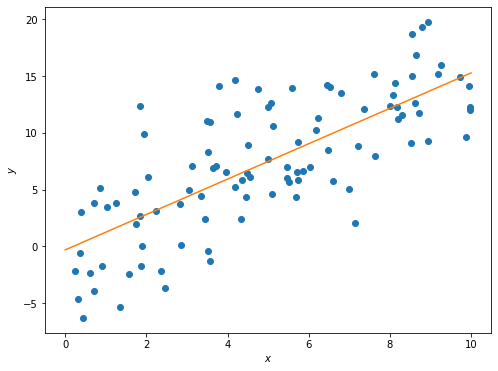

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.plot(np.linspace(0, 10), slope * np.linspace(0, 10) + intercept, color='tab:orange')
plt.xlabel('$x$')
plt.ylabel('$y$');
print('Slope: ', slope)

Now the estimated slope is roughly 1.6, even though the underlying data was still generated using a slope of 1.5. This is a very important concept that we will revisit soon.

Keep in mind, however, that correlation in data *does not* imply causation. In this example we know the true causal relationship between $x$ and $y$ because we defined it ourselves. However, when using real data you do not see the "true" relation and thus cannot conclude causality from correlation. It could simply be that both your variables depend on an unseen third variable and have no causal effect on one another. Or even worse, while unlikely it could be the case that slight linear trends in two variables is a complete coincidence.

## Root-Mean-Squared Error

While we can arbitrarily pick $\hat{\alpha}$ and $\hat{\beta}$ values, we do want to pick the values that help predict $\hat{y}$ that are closest to actual $y$ values. To achieve this, we want to minimize a **loss function** that quantifies how far off our prediction $\hat{y}$ is from $y$ for some known data points. One of the most common loss functions is called the **root-mean-squared error**, and is defined as

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left ( y_i - \hat{y}_i \right ) ^2 }
$$

where $n$ is the number of observations. The effect of this is to take the mean of the distance of each value of $\hat{y}$ from its corresponding value in $y$; squaring these values keeps them positive, and then we take the square root to correct the units of the error.

Plugging in the formula $\hat{y}$ in RMSE formula, we get,

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left ( y_i - (\hat{\alpha} + \hat{\beta}x_i) \right ) ^2 }
$$

By doing a bit of calculus, we get the following formulas for $\hat{\alpha}$ and $\hat{\beta}$

$$\Large
\hat{\beta} = r\frac {\hat{\sigma}_y} {\hat{\sigma}_x} \qquad \qquad
\hat{\alpha} = \hat{\mu}_y - \hat{\beta}\hat{\mu}_x
$$

where $r$ is the **correlation** between $x$ and $y$, $\hat{\sigma}_y$ is the standard deviation of $y$, $\hat{\sigma}_x$ is the standard deviation of $x$, $\hat{\mu}_y$ is the average of all our $y$ values, and $\hat{\mu}_x$ is the average of all our $x$ values. (As an aside, note the hats on our $\sigma$'s and $\mu$'s; this is because these are _empirical estimates_ of the parameters of these distributions, rather than the true values.) These are the same values we had above!

Note that our formula for $\hat{\beta}$ involves the **correlation coefficient** $r$ of $x$ and $y$. The correlation coefficient of two variables is a measure of the strength of a linear relationship between them. $r$ goes from -1 to 1, where $|r|=1$ is a perfect linear relationship and $r=0$ is no linear relationship. The formula for $r$ is

$$
r = \frac{1}{n}\sum^n_{i=1} \left ( \frac{x_i - \hat{\mu}_x}{\hat{\sigma}_x} \right ) \left ( \frac{y_i - \hat{\mu}_y}{\hat{\sigma}_y} \right )
$$

(Note: the form $\frac{x_i - \hat{\mu}_x}{\hat{\sigma}_x}$ of a variable $x$ is it's representation in standard units, as mentioned above.)

To calculate the RMSE, we will write an `rmse` function that makes use of sklearn's `mean_squared_error` function.

In [14]:
def rmse(target, pred):
    return np.sqrt(mean_squared_error(target, pred))

To get a better idea of what the RMSE represents, the figures below show a small dataset, a proposed regression line, and the squared error that we are summing in the RMSE. The data points are

| $x$ | $y$ |
|-----|-----|
| 0 | 1 |
| 1 | .5 |
| 2 | -1 |
| 3 | 2 |
| 4 | -3 |

Here are the proposed regression lines and their errors:

![se_slope_1.png](se_slope_1.png)

![se_slope_-1.png](se_slope_-1.png)

In [15]:
d = Table().with_columns(
    'x', make_array(0,  1,  2,  3,  4),
    'y', make_array(1, .5, -1,  2, -3))

def plot_line_and_errors(slope, intercept):
    print("RMSE:", rmse(slope * d.column('x') + intercept, d.column('y')))
    plt.figure(figsize=(5,5))
    points = make_array(-2, 7)
    p = plt.plot(points, slope*points + intercept, color='orange', label='Proposed line')
    ax = p[0].axes
    
    predicted_ys = slope*d.column('x') + intercept
    diffs = predicted_ys - d.column('y')
    for i in np.arange(d.num_rows):
        x = d.column('x').item(i)
        y = d.column('y').item(i)
        diff = diffs.item(i)
        
        if diff > 0:
            bottom_left_x = x
            bottom_left_y = y
        else:
            bottom_left_x = x + diff
            bottom_left_y = y + diff
        
        ax.add_patch(patches.Rectangle(make_array(bottom_left_x, bottom_left_y), abs(diff), abs(diff), color='red', alpha=.3, label=('Squared error' if i == 0 else None)))
        plt.plot(make_array(x, x), make_array(y, y + diff), color='red', alpha=.6, label=('Error' if i == 0 else None))
    
    plt.scatter(d.column('x'), d.column('y'), color='blue', label='Points')
    
    plt.xlim(-4, 8)
    plt.ylim(-6, 6)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend(bbox_to_anchor=(1.8, .8))
    plt.show()

interact(plot_line_and_errors, slope=widgets.FloatSlider(min=-4, max=4, step=.1), intercept=widgets.FloatSlider(min=-4, max=4, step=.1));

interactive(children=(FloatSlider(value=0.0, description='slope', max=4.0, min=-4.0), FloatSlider(value=0.0, d…

## Econometric Single Variable Regression

The regression line can have two purposes:

* Of particular interest to data scientists is the line's ability to predict values of $y$ for new values of $x$ that we didn't see before.

* Of particular interest to economists is the line's ability to estimate the "true" underlying slope of the data via its slope.

This is why regression is such a powerful tool and forms the backbone of econometrics. If we believe that our data satisfy certain assumptions (which we won't explore too much this lecture), then we can use the slope of the regression line to estimate the "true" relation between the variables in question and learn more about the world we live in.

In econometrics, we usually write the "true" underlying linear relationship as follows:

$$
y = \alpha + \beta \cdot x + \varepsilon
$$

where $y$ and $x$ are values for any arbitrary point, $\alpha$ is the intercept, $\beta$ is the slope, and $\varepsilon$ is some noise. This is entirely analogous to the code from earlier that determined the true linear relationship between the data:

```python
y = 1.5 * x + noise
```

Here, $\beta = 1.5$, $\alpha = 0$, and $\varepsilon = \text{noise}$.

When we fit a regression line onto the data, we express the line as:

$$
\hat{y} = \hat{\alpha} + \hat{\beta} \cdot x
$$

Here, we put hats over the slope and intercept terms because they are *estimates* of the true slope and intercept terms. Similarly, we put a hat over $y$ because this is the $y$ value that the regression line predicts.

Notice how the noise term $\varepsilon$ does not appear in the expression for the regression line. This is because the noise term is a random variable that has no relation with $x$, and is thus impossible to predict from the data. Furthermore, the noise term has a mean value of 0, so on average we actually don't expect the noise term to have any impact on the underlying trends of the data.

For the Data 8 demonstration above, we forced these conditions to be true. However, with real data these are assumptions that we have to make, and is something that econometricians spend a lot of time thinking about.

### Years of Schooling and Earnings

Consider a case where we want to study how years of schooling relate to a person's earnings. This should be of particular interest to college students. Below we import a dataset that has the hourly wage, years of schooling, and other information on thousands of people sampled in the March 2012 Current Population Survey.

In [16]:
cps = Table.read_table('cps.csv')
cps

state,age,wagesal,imm,hispanic,black,asian,educ,wage,logwage,female,fedwkr,statewkr,localwkr
11,44,18000,0,0,0,0,14,9.10931,2.2093,1,1,0,0
11,39,18000,0,0,0,0,14,18,2.89037,0,0,0,0
11,39,35600,0,0,0,0,12,17.1154,2.83998,0,0,0,1
11,39,8000,0,0,0,0,14,5.12821,1.63476,1,0,0,0
11,39,100000,0,0,0,0,16,38.4615,3.64966,0,1,0,0
11,43,25000,0,0,0,0,12,10,2.30259,0,0,0,0
11,38,25000,0,0,0,0,16,27.1739,3.30226,1,0,0,0
11,39,26000,0,0,0,0,13,16.6667,2.81341,1,0,0,0
11,39,52000,0,0,0,0,16,16.6667,2.81341,0,0,0,0
11,37,4500,0,0,0,0,13,4,1.38629,1,0,0,0


We want to consider a person's wage and years of schooling. But first, we will convert wage to log-wage. Wage is a variable that we would expect to increase proportionally (or, exponentially) with changes in years of schooling. And as such, we usually take the natural log of wage instead. Below we plot log wage and years of schooling for the CPS data.

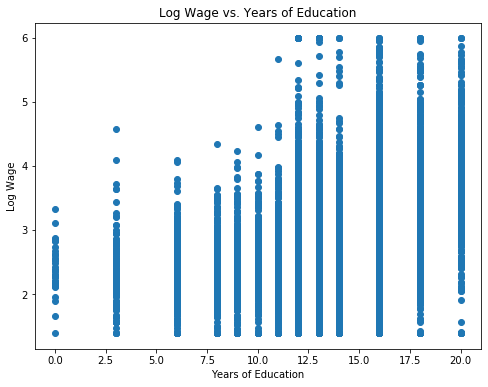

In [20]:
educ = cps.column('educ')
logwage = cps.column('logwage')

plt.figure(figsize=(8,6))
plt.scatter(educ, logwage)
plt.xlabel('Years of Education')
plt.ylabel('Log Wage')
plt.title('Log Wage vs. Years of Education');

Now let's fit a least-squares regression line onto this data. First, we'll do it manually in the Data 8 style above.

In [21]:
educ_standard = standard_units(educ)
logwage_standard = standard_units(logwage)

r = correlation(logwage_standard, educ_standard)
slope = r * np.std(logwage) / np.std(educ)
intercept = np.mean(logwage) - slope * np.mean(educ)

Slope:  0.10781133924799272
Intercept:  1.472287673006932


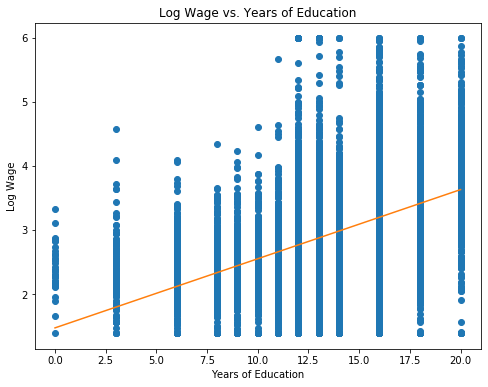

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(educ, logwage)
plt.plot(np.linspace(0, 20), slope * np.linspace(0, 20) + intercept, color='tab:orange')
plt.xlabel('Years of Education')
plt.ylabel('Log Wage')
plt.title('Log Wage vs. Years of Education');
print('Slope: ', slope)
print('Intercept: ', intercept)

So from the very simple and straight-forward model above, it seems that we estimate a slope of roughly 0.1, meaning we might expect that a one-year increase in schooling is associated with a 10% increase in wage, on average.

We can also see that we have a non-zero intercept term. We should be careful how we interpret this term; from a strictly mathematical point of view, the intercept represents the expected value of $y$ (in this case log wage) when $x = 0$. However, in economics sometimes it makes no sense for $x$ to be 0, and so we cannot use the above interpretation. We won't go into detail this lecture, but regardless of whether the intercept is interpretable, we almost always want to include it.

## Uncertainty in $\hat{\beta}$

We mentioned earlier that the slope we estimate from regression is exactly that: an estimate of the "true" underlying slope. Because of this, the estimate $\hat{\beta}$ is a random variable that depends on the underlying data.

Let's assume there is the following true linear relation between log wage and years of schooling,

$$
\text{logwage} = \alpha + \beta \cdot \text{years of schooling} + \varepsilon
$$

and we try to estimate $\alpha$ and $\beta$.

If our data are "well-behaved", then even though there is uncertainty in our estimate $\hat{\beta}$, on average $\hat{\beta}$ will be $\beta$; that is to say that the expectation of $\hat{\beta}$ is $\beta$. Additionally, if our data are "well-behaved", then $\hat{\beta}$ has some normal distribution with mean $\beta$. We won't worry too much about what assumptions need to be satisfied to make the data "well-behaved".

You can think of each person as an observation of these variables, and using a sample of people we can estimate the relationship between the two variables. However, due to the noise term and the fact that we only have a finite sample of people, the true relationship is always hidden from us, and we can only hope to get better estimates by designing better experiments and sampling more people.

Let's try to get an idea of how "certain" we can be of our estimate $\hat{\beta}$. We'll do this in classic Data 8 style: bootstrapping. Using our existing sample data, we'll create new samples by bootstrapping from the existing data. Then, for each sample, we'll fit a line, and keep the slope of that line in a list with all of the other slopes. Then, we'll find the standard deviation of that list of slopes.

Standard dev. of bootstrapped slopes:  0.0015948419317821812


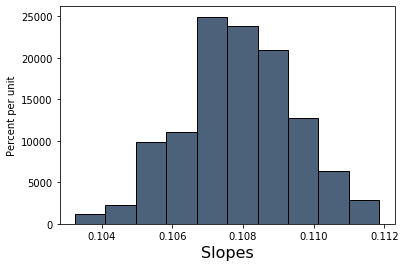

In [23]:
slopes = make_array()
educ_logwage = cps.select("educ", "logwage")

np.random.seed(42)
for i in np.arange(200):
    educ_logwage_sample = educ_logwage.sample()
    y = educ_logwage_sample.column("logwage")
    X = educ_logwage_sample.column("educ")
    model = sm.OLS(y, sm.add_constant(X)).fit()
    slopes  = np.append(model.params[1], slopes)
    
Table().with_columns("Slopes", slopes).hist()    
print('Standard dev. of bootstrapped slopes: ', np.std(slopes))

Our bootstrapped approximation standard error of 0.00159 is pretty close to the true standard error of 0.00144. `statsmodels`, the package we will be using to perform regressions, actually uses a precise mathematical formula for finding the standard error whereas we tried to find this value through simulation, but the idea behind the standard error is the same.

Armed with a standard error, we can now form a 95% confidence interval and perform a test of significance to see if $\hat{\beta}$ is significantly different from 0.

In [24]:
# Using our resampled slopes
lower_bound = percentile(2.5, slopes)
upper_bound = percentile(97.5, slopes)
print('95% confidence interval: [{}, {}]'.format(lower_bound, upper_bound))

95% confidence interval: [0.1045603129388414, 0.1109373558983047]


The 95% confidence interval does not contain 0, and so $\beta$ is unlikely to be 0.

## Regression with a Binary Variable

A binary variable is a variable that takes on the value of 1 if some condition is true, and 0 otherwise. These are also called dummy variables or indicator variables. It might sound strange at first, but you can actually perform regression of a variable like log earnings onto a binary variable.

Let's import a different dataset that has the following features. Some will be useful to us later.

In [25]:
nlsy = Table.read_table('nlsy_cleaned_small.csv')
nlsy

male,AFQT,real_earnings_1999,weeks_worked_1999,log_earn_1999,college,mother_college,father_college
1,99.393,52354.4,52,10.8658,1,0,0
1,47.412,32721.5,52,10.3958,0,0,0
0,44.022,35862.8,52,10.4875,0,0,0
1,59.683,68060.7,52,11.1282,0,0,0
1,72.313,78531.6,52,11.2713,1,0,1
0,98.798,62825.3,52,11.0481,1,0,0
0,50.283,49736.7,52,10.8145,0,0,0
1,89.669,62825.3,52,11.0481,0,0,0
1,95.977,259311,52,12.4658,0,0,1
0,67.021,68060.7,52,11.1282,1,0,1


Now let's visualize log earnings vs. the binary variable corresponding to whether or not an observation went to college.

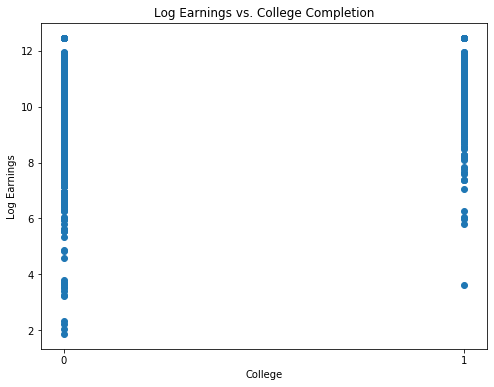

In [26]:
coll = nlsy.column('college')
logearn = nlsy.column('log_earn_1999')

plt.figure(figsize=(8,6))
plt.scatter(coll, logearn)
plt.xlabel('College')
plt.ylabel('Log Earnings')
plt.title('Log Earnings vs. College Completion')
plt.xticks([0,1]);

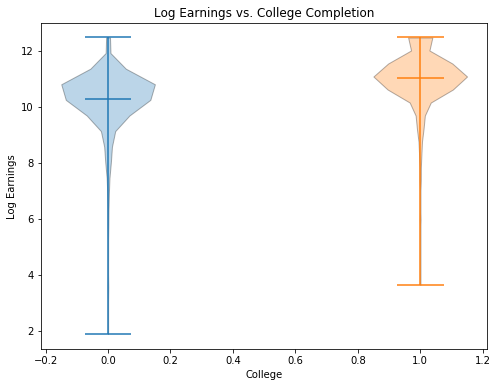

In [27]:
no_college = nlsy.where('college', 0).column("log_earn_1999")
has_college = nlsy.where('college', 1).column("log_earn_1999")

plt.figure(figsize=(8,6))
plt.xlabel('College')
plt.ylabel('Log Earnings')
plt.title('Log Earnings vs. College Completion')
plt.violinplot(no_college, positions = [0], points=20, widths=0.3, showmeans=True, showextrema=True, showmedians=False)
plt.violinplot(has_college, positions = [1], points=20, widths=0.3, showmeans=True, showextrema=True, showmedians=False);

Now let's fit a regression model:

In [28]:
coll_standard = standard_units(coll)
logearn_standard = standard_units(logearn)

r = correlation(logearn_standard, coll_standard)
slope = r * np.std(logearn) / np.std(coll)
intercept = np.mean(logearn) - slope * np.mean(coll)

print("y = {:.5f} * x + {:.5f}".format(slope, intercept))

y = 0.72389 * x + 10.27883


Wow! This regression would imply that we expect, on average, observations who went to college to have 70% higher earnings than those who did not go to college. Let's now plot this line on the data:

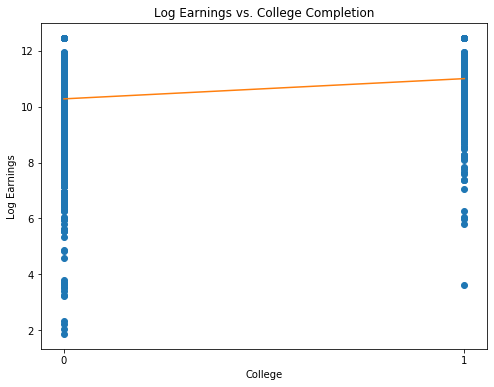

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(coll, logearn)
plt.plot(np.linspace(0, 1), slope * np.linspace(0, 1) + intercept, color='tab:orange')
plt.xlabel('College')
plt.ylabel('Log Earnings')
plt.title('Log Earnings vs. College Completion')
plt.xticks([0,1]);

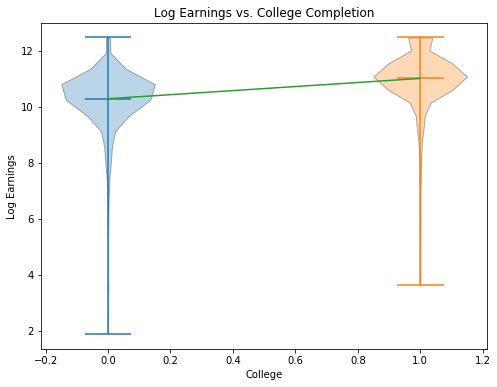

In [34]:
no_college = nlsy.where('college', 0).column("log_earn_1999")
has_college = nlsy.where('college', 1).column("log_earn_1999")

plt.figure(figsize=(8,6))
plt.plot(np.linspace(0, 1), slope * np.linspace(0, 1) + intercept, color='tab:green')
plt.xlabel('College')
plt.ylabel('Log Earnings')
plt.title('Log Earnings vs. College Completion')
plt.violinplot(no_college, positions = [0], points=20, widths=0.3, showmeans=True, showextrema=True, showmedians=False)
plt.violinplot(has_college, positions = [1], points=20, widths=0.3, showmeans=True, showextrema=True, showmedians=False);

When we perform a simple regression onto just a dummy variable, it is an important fact that $\hat{\alpha}$ is the mean value of $y$ for all observations in the sample where $x = 0$, and $\hat{\beta}$ is the difference between the mean value of $y$ for observations in the sample where $x = 1$ and observations where $x = 0$. Proving this claim is beyond our scope this week, but let's verify it with our data:

In [31]:
avg_logearn_coll = np.mean(logearn[coll == 1])
avg_logearn_nocoll = np.mean(logearn[coll == 0])

print('Avg logearn for coll = 1: ', avg_logearn_coll)
print('Avg logearn for coll = 0: ', avg_logearn_nocoll)
print('Difference between the two: ', avg_logearn_coll - avg_logearn_nocoll)

Avg logearn for coll = 1:  11.002722859240283
Avg logearn for coll = 0:  10.278831734712744
Difference between the two:  0.7238911245275386


In [32]:
print('Intercept: ', intercept)
print('Slope: ', slope)

Intercept:  10.278831734712744
Slope:  0.72389112452754
